# **Linking Writing Processes to Writing Quality**
### Use typing behavior to predict essay quality

This notebook is modified from the following notebooks:  
[EDA for better data understanding](https://www.kaggle.com/code/datark1/eda-for-better-data-understanding)  
[Feature Engineering: Sentence & paragraph features](https://www.kaggle.com/code/hiarsl/feature-engineering-sentence-paragraph-features)  
[📒 Writing Processes to Quality - Baseline](https://www.kaggle.com/code/mcpenguin/writing-processes-to-quality-baseline)  
[Silver Bullet | Single Model | 165 Features](https://www.kaggle.com/code/awqatak/silver-bullet-single-model-165-features)  

## Set Global Configuration Options

In [1]:
class CONFIG:
    '''
    > General Options
    '''
    # global seed
    seed = 42
    # the number of samples to use for testing purposes
    # if None, we use the full dataset
    samples_testing = None #None
    # max rows to display for pandas dataframes
    display_max_rows = 100
    # name of the response variate# Get feature importances from the model we are trying to predict
    response_variate = 'score'
    
    '''
    > Preprocessing Options
    '''
    # number of folds to split the data for CV
    num_folds = 10
    
    '''
    > Feature Engineering Options
    '''
    num_cols = ["down_time", "up_time", "action_time", "cursor_position", "word_count"]
    activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
    events = ["q", "Space", "Backspace", "Shift", "ArrowRight", "Leftclick", "ArrowLeft", ".", ",", "ArrowDown", "ArrowUp", "Enter", "CapsLock", "'", "Delete", "Unidentified"]
    text_changes = ["q", " ", ".", ",", "\n", "'", "-", "?", ";", "=", "/", "\\", ":"]
    
    '''
    > Modelling Options
    '''
    # whether to use optuna tuning or not
    # if False, then we load in pretuned weights for the LGBM models
    use_optuna_tuning = True
    # size of the test set for optuna tuning
    # if use_optuna_tuning=True
    test_size_optuna = 0.2
    # number of estimators to use for the boosting model
    num_estimators = 5000
    # number of trials to use for optuna tuning
    # if use_optuna_tuning=True
    num_trials_optuna = 80
    # number of trials to use for early stopping
    num_trials_early_stopping = 40
    # parameters
    best_params = {
        'reg_alpha': 0.30650185736659397, 
        'reg_lambda': 0.08235806165155644, 
        'colsample_bytree': 0.5547938642836329, 
        'subsample': 0.782269098248984, 
        'learning_rate': 0.02572229832068531, 
        'num_leaves': 14, 
        'min_child_samples': 43
    }
    
    '''
    > Post-Modelling Options
    '''
    # number of most important features to display
    # for the feature importances plot
    num_features_to_display = 50

## Import Libraries

In [2]:
import os
import warnings
import re
import copy
import optuna

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from collections import Counter
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import skew, kurtosis
from lightgbm import LGBMRegressor
warnings.filterwarnings("ignore")

## Read in data

In [3]:
train_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv')
train_scores = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')

test_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv')

DATA_DIR = '/kaggle/input/linking-writing-processes-to-writing-quality/'

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv
/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv


In [4]:
train_essays = pd.read_csv('/kaggle/input/writing-quality-challenge-constructed-essays/train_essays_fast.csv')
train_essays.head()

,id,essay
0,001519c8,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...
1,0022f953,"qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq..."
2,0042269b,qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...
3,0059420b,qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...
4,0075873a,"qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq..."


## Data dictionary

Let's dicover the data which are composed of :
- events
- activities
- scores

**Events**

| Column             | Definition                                                                |
| ------------------ | ------------------------------------------------------------------------- |
| essay_id_comp      | The unique ID of the essay                                                |
| event_id           | The index of the event, ordered chronologically                           |
| down_time          | The time of the down event in milliseconds                                |
| up_time            | The time of the up event in milliseconds                                  |
| action_time        | The duration of the event (the difference between down_time and up_time)  |
| activity           | The category of activity which the event belongs to                       |
| down_event         | The name of the event when the key/mouse is pressed                       |
| up_event           | The name of the event when the key/mouse is released                      |
| text_change        | The text that changed as a result of the event (if any)                   |
| cursor_position    | The character index of the text cursor after the event                    |
| word_count         | The word count of the essay after the event                               |

**Activities**

| Activity Name                  | Definition                                                                                 |
| ------------------------------ | ------------------------------------------------------------------------------------------ |
| Nonproduction                  | The event does not alter the text in any way                                               |
| Input                          | The event adds text to the essay                                                           |
| Remove/Cut                     | The event removes text from the essay                                                      |
| Paste                          | The event changes the text through a paste input                                           |
| Replace                        | The event replaces a section of text with another string                                   |
| Move From [x1, y1] To [x2, y2] | The event moves a section of text spanning character index x1, y1 to a new location x2, y2 |

**Scores**

| Column         | Definition                                                                        |
| -------------- | --------------------------------------------------------------------------------- |
| essay_id_comp  | The unique ID of the essay                                                        |
| score          | The score the essay received out of 6 (the prediction target for the competition) |
| split          | The train-test split of the essay                                                 |

## Data Exploration

In [5]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


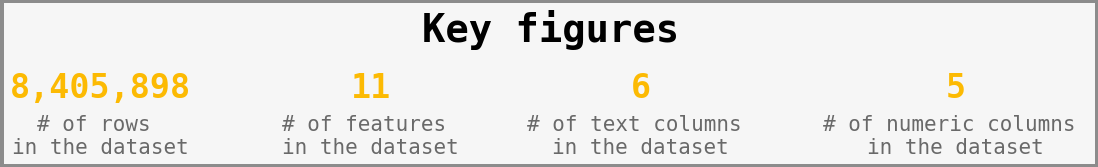

In [6]:
mpl.rcParams.update(mpl.rcParamsDefault)

data = train_logs.copy()
art_dtypes = data.dtypes.value_counts()

fig = plt.figure(figsize=(5,2),facecolor='white')
ax0 = fig.add_subplot(1,1,1)
ax0.text(1, 0.8, "Key figures",color='black',fontsize=28, fontweight='bold', fontfamily='monospace', ha='center')

ax0.text(0, 0.4, "{:,d}".format(data.shape[0]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily='monospace', ha='center')
ax0.text(0, 0.001, "# of rows \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily='monospace',ha='center')

ax0.text(0.6, 0.4, "{}".format(data.shape[1]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily='monospace', ha='center')
ax0.text(0.6, 0.001, "# of features \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily='monospace',ha='center')

ax0.text(1.2, 0.4, "{}".format(art_dtypes[0]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily='monospace', ha='center')
ax0.text(1.2, 0.001, "# of text columns \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily='monospace',ha='center')

ax0.text(1.9, 0.4,"{}".format(art_dtypes[1]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily='monospace', ha='center')
ax0.text(1.9, 0.001,"# of numeric columns \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily='monospace',ha='center')

ax0.set_yticklabels('')
ax0.tick_params(axis='y',length=0)
ax0.tick_params(axis='x',length=0)
ax0.set_xticklabels('')

for direction in ['top','right','left','bottom']:
    ax0.spines[direction].set_visible(False)

fig.subplots_adjust(top=0.9, bottom=0.2, left=0, hspace=1)

fig.patch.set_linewidth(5)
fig.patch.set_edgecolor('#8c8c8c')
fig.patch.set_facecolor('#f6f6f6')
ax0.set_facecolor('#f6f6f6')
    
plt.show()

In [7]:
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


## Target variable: "Score"

In [8]:
print(f"Minimum score is: {train_scores['score'].min()}")
print(f"Maximum score is: {train_scores['score'].max()}")

Minimum score is: 0.5
Maximum score is: 6.0


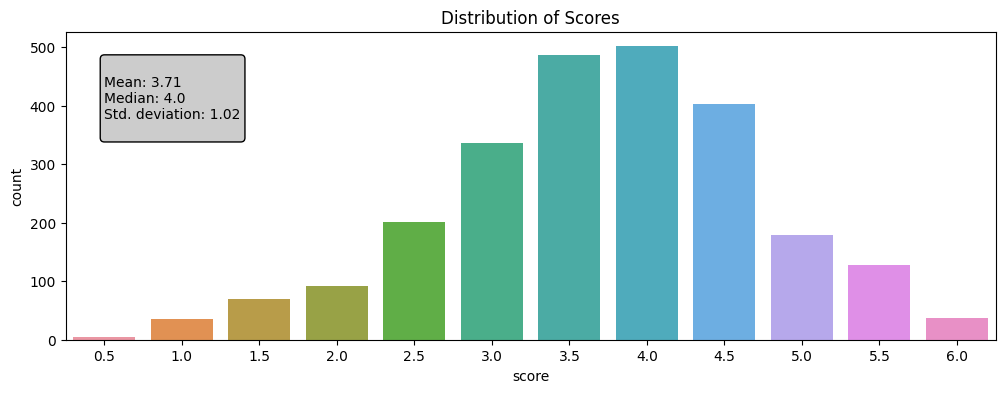

In [9]:
# Display the distribution of scores
text = f"""
Mean: {train_scores['score']
.mean().round(2)}
Median: {train_scores['score'].median().round(2)}
Std. deviation: {train_scores['score'].std().round(2)}
"""
bbox = dict(boxstyle = "round", fc = "0.8")

f, ax = plt.subplots(figsize = (12, 4))
ax = sns.countplot(
    data = train_scores,
    x = "score"
)
ax.set_title("Distribution of Scores")
ax.annotate(text, (0, 350), bbox = bbox)
plt.show()

## Variables "id" and "event"

In [10]:
print(f'Number of unique essays in train: {train_logs["id"].nunique()}')
print(f'Number of unique essays in test:  {test_logs["id"].nunique()}')

Number of unique essays in train: 2471
Number of unique essays in test:  3


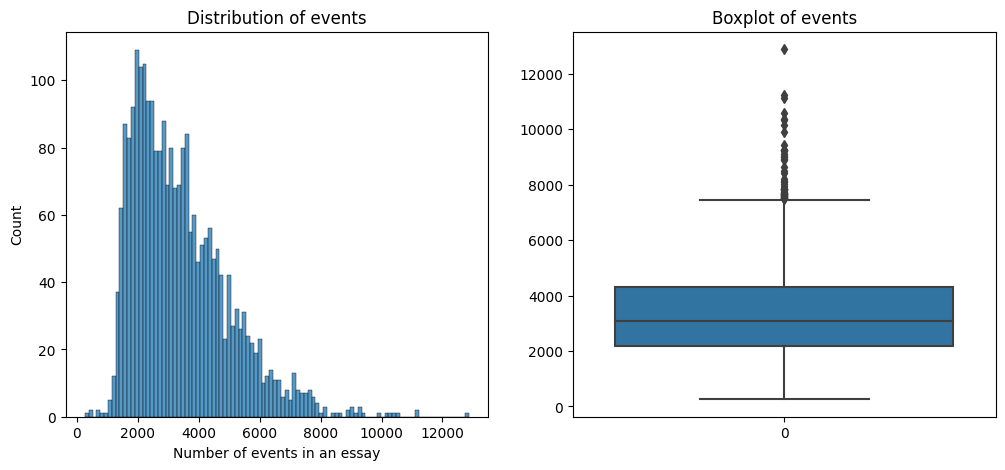

In [11]:
# Display the distribution of events by essay
event_stats = train_logs.groupby("id")['event_id'].max()

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Distribution of events')
ax[0].set_xlabel('Number of events in an essay')
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of events')
sns.boxplot(event_stats, ax=ax[1])
plt.show()

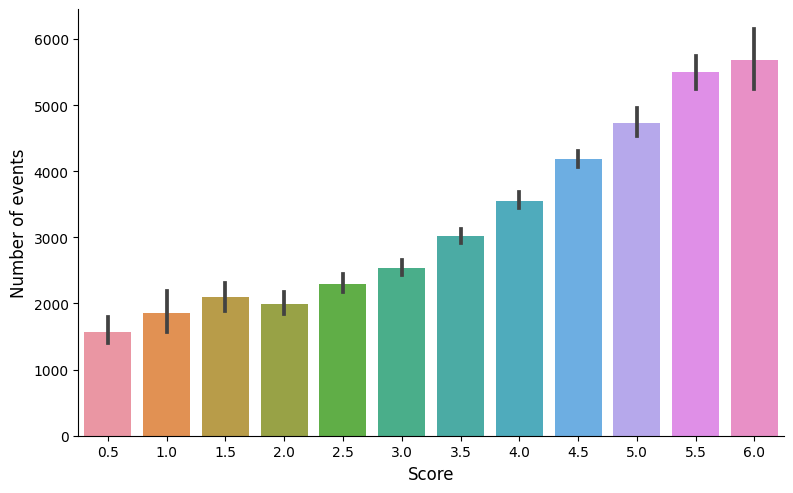

In [12]:
# Check for correlation between the number of events and the score
stats_score = train_logs.groupby("id")["event_id"].max().reset_index().merge(train_scores, on = "id")

catplot = sns.catplot(
    data = stats_score,
    x = "score",
    y = "event_id",
    kind = "bar",
    height = 5,
    aspect = 8/5
)
plt.xlabel("Score", fontsize = 12)
plt.ylabel("Number of events", fontsize = 12)
plt.show()

From this plot, there is evidence of positive correlation between the number of events in an essay and the final score

## Variables "down_time", "up_time", and "action_time"

`down_time` - The time of the down event in milliseconds  
`up_time` - The time of the up event in milliseconds  
`action_time` - The duration of the event (the difference between down_time and up_time)  

In [13]:
# Check to make sure action_time = up_time - down_time
tmp = train_logs["up_time"] - train_logs["down_time"]
results = (tmp == train_logs["action_time"])
results.value_counts()

True    8405898
Name: count, dtype: int64

action_time is indeed calculated correctly for each row, so that variable can be trusted

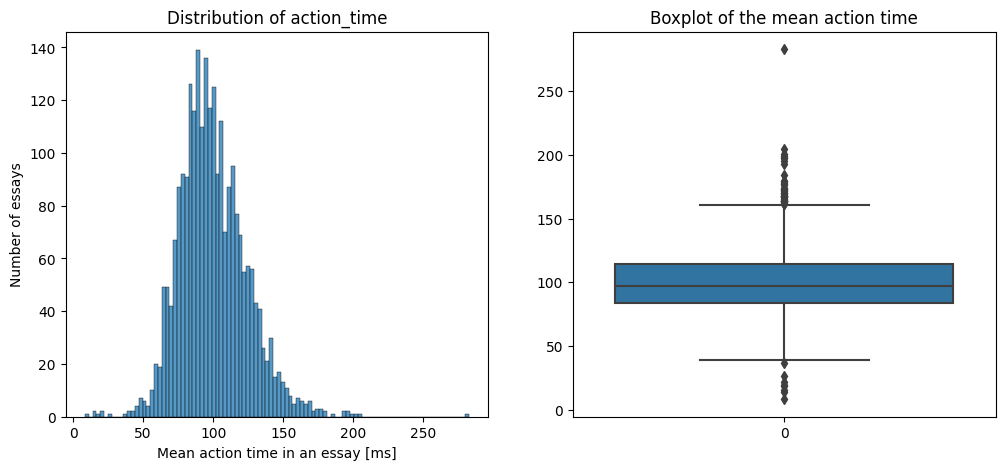

In [14]:
# Display the distribution of action_time
stats = train_logs.groupby("id")["action_time"].mean()

fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].set_title("Distribution of action_time")
ax[0].set_xlabel("Mean action time in an essay [ms]")
ax[0].set_ylabel("Number of essays")
sns.histplot(
        stats,
        bins = 100,
        ax = ax[0]
        )
ax[1].set_title("Boxplot of the mean action time")
sns.boxplot(
        stats,
        ax = ax[1]
        )
plt.show()

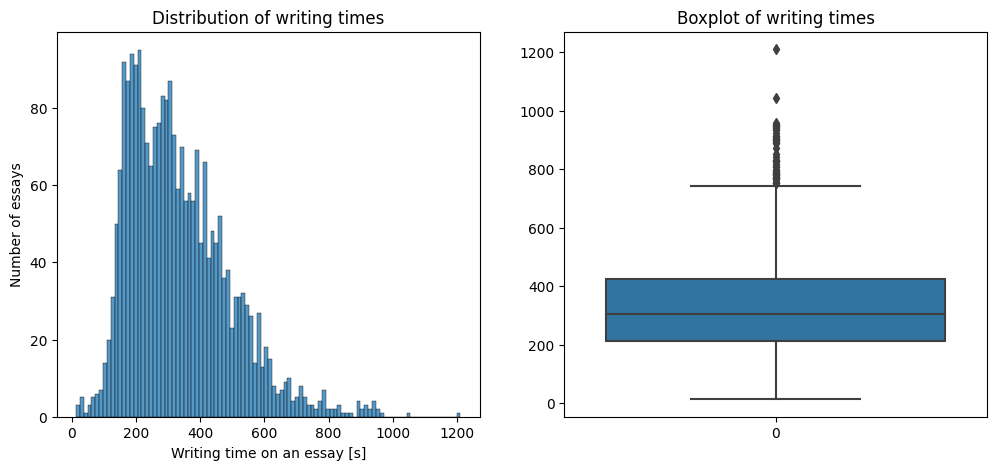

In [15]:
# Display the distribution of total writing time
stats = train_logs.groupby("id")["action_time"].sum().div(1000)

fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].set_title('Distribution of writing times')
ax[0].set_xlabel('Writing time on an essay [s]')
ax[0].set_ylabel('Number of essays')
sns.histplot(stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of writing times')
sns.boxplot(stats, ax=ax[1])
plt.show()


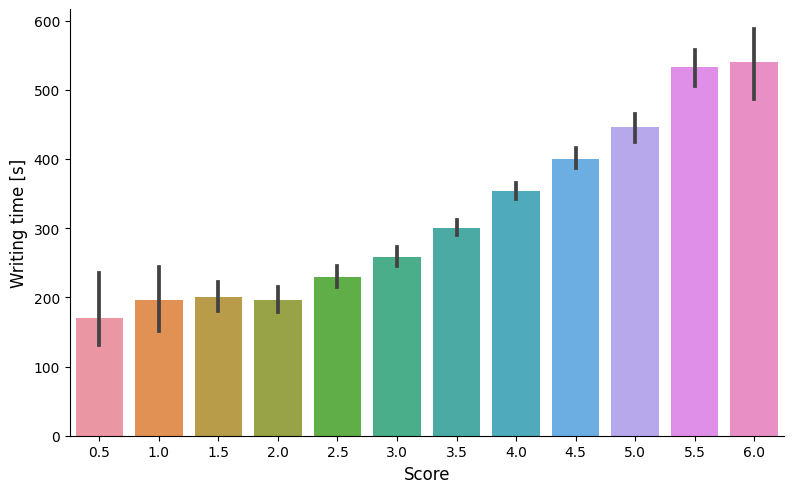

In [16]:
# Check for correlation between writing time and essay score
stats_score = train_logs.groupby("id")["action_time"].sum().div(1000).reset_index().merge(train_scores, on = "id")

catplot = sns.catplot(
        data = stats_score,
        x = "score",
        y = "action_time",
        kind = "bar",
        height = 5,
        aspect = 8/5
        )
plt.xlabel("Score", fontsize = 12)
plt.ylabel("Writing time [s]", fontsize = 12)
plt.show()

From this plot, there is evidence of positive correlation between the total writing time and the essay score

### Variable "activity"

`activity` is the category of activity which the event belongs to. There are 6 types of activities:

1. `Nonproduction` - The event does not alter the text in any way
2. `Input` - The event adds text to the essay
3. `Remove/Cut` - The event removes text from the essay
4. `Paste` - The event changes the text through a paste input
5. `Replace` - The event replaces a section of text with another string
6. `Move From [x1, y1] To [x2, y2]` - The event moves a section of text spanning character index x1, y1 to a new location x2, y2

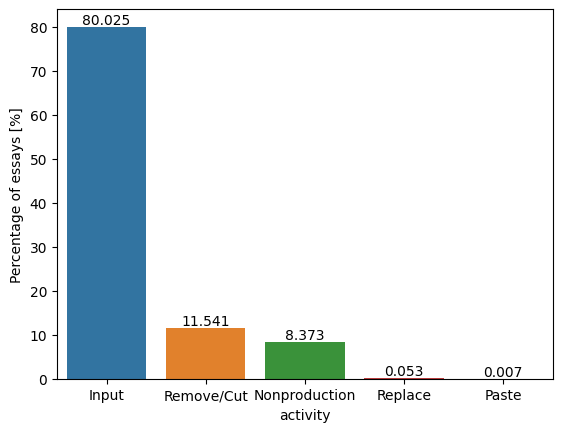

In [17]:
vals_of_interest = [
        "Nonproduction",
        "Input",
        "Remove/Cut",
        "Paste",
        "Replace"
        ]
sub_df = train_logs[train_logs["activity"].isin(vals_of_interest)]["activity"]

tmp_stats = sub_df.value_counts()\
        .div(len(sub_df))\
        .mul(100)\
        .round(3)\
        .reset_index()

ax = sns.barplot(
        tmp_stats,
        x = "activity",
        y = "count",
        errorbar = None
        )

ax.bar_label(ax.containers[0], fontsize = 10)
ax.set_ylabel("Percentage of essays [%]")
plt.show()

### Variables "down_event" and "up_event"

In [18]:
# List the most common events
train_logs["down_event"].value_counts()[:20]

down_event
q               5365319
Space           1207128
Backspace        964089
Shift            334227
ArrowRight       121338
Leftclick         91126
ArrowLeft         63217
.                 59586
,                 46806
ArrowDown         30874
ArrowUp           28189
Enter             22689
CapsLock          12568
'                 11170
Delete            10965
Unidentified       6151
Control            4885
"                  4102
-                  3843
?                  3155
Name: count, dtype: int64

The most common down event is "q", which in this case represents any alphanumeric character. 

In [19]:
print(f'Number of unique down events: {train_logs["down_event"].nunique()}')
print(f'Number of unique up events: {train_logs["up_event"].nunique()}')

Number of unique down events: 131
Number of unique up events: 130


In [20]:
# Investigate which up events are not present in the set of down events
set(train_logs["up_event"].unique()).difference(set(train_logs["down_event"].unique()))

{'k'}

In [21]:
# Investigate which down events are not present in the set of up events
set(train_logs["down_event"].unique()).difference(set(train_logs["up_event"].unique()))

{'F', 'I'}

In [22]:
# Investigate the fastest and slowest events
event_stats = train_logs[["down_event", "up_event", "action_time"]]\
        .groupby("down_event")["action_time"]\
        .mean()\
        .sort_values()

# Fastest events
event_stats[:10]

down_event
j          0.0
l          0.0
F1         0.0
Pause      0.0
Control    0.0
Shift      0.0
T          0.0
Alt        0.0
F6         0.0
f          0.2
Name: action_time, dtype: float64

In [23]:
# Slowest events
event_stats[-10:]

down_event
CapsLock        189.622215
Å              221.000000
C               222.000000
Leftclick       263.812425
Rightclick      320.974046
Meta            675.605428
ModeChange     1882.864865
F3             2212.555556
n              6237.750000
Process       35134.538462
Name: action_time, dtype: float64

The slowest events by far are: "Process", "n", "F3", and "ModeChange". It would be useful to know what these events mean. However, as we can see from the distribution of events, these are very rare events.

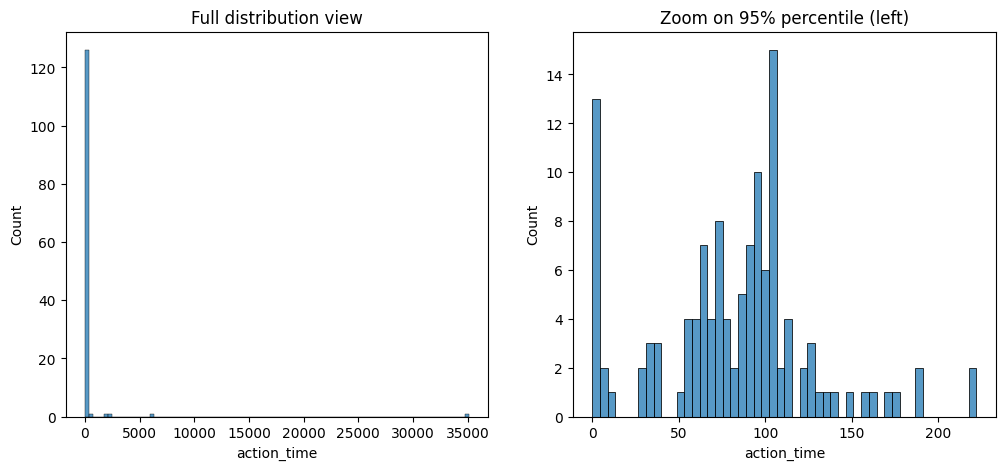

In [24]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Full distribution view')
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Zoom on 95% percentile (left)')
event_stats_95 = event_stats[event_stats<event_stats.quantile(0.95)]
sns.histplot(event_stats_95, bins=50, ax=ax[1])
plt.show()

### Variable "word_count"

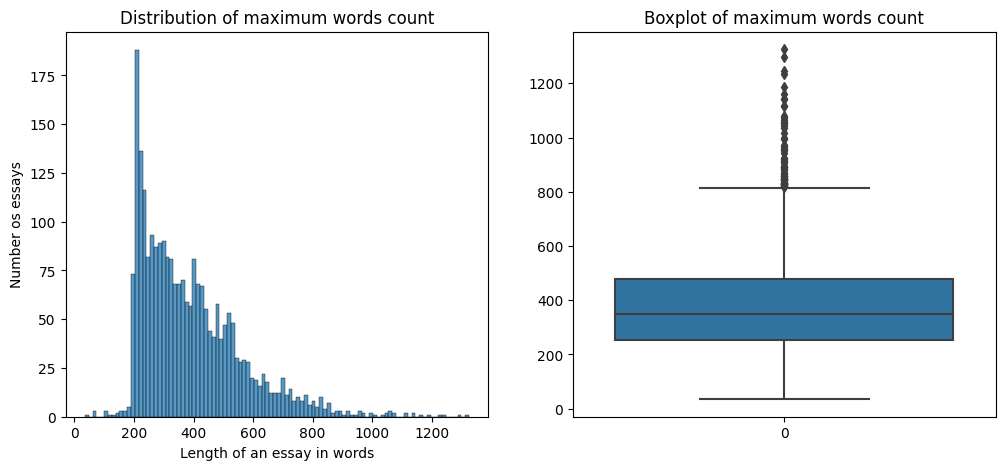

In [25]:
# Display the distribution of word counts
event_stats = train_logs.groupby("id")['word_count'].max()

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Distribution of maximum words count')
ax[0].set_xlabel('Length of an essay in words')
ax[0].set_ylabel('Number os essays')
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of maximum words count')
sns.boxplot(event_stats, ax=ax[1])
plt.show()

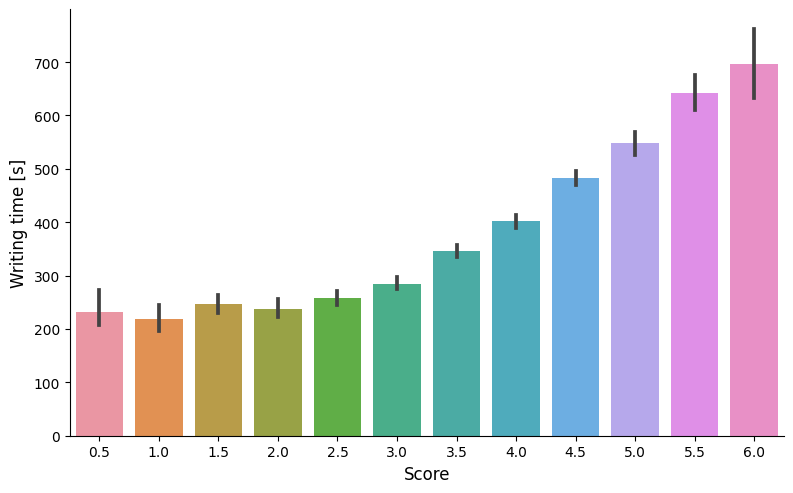

In [26]:
# Check for correlation between word count and score
stats_score = train_logs.groupby("id")["word_count"]\
        .max()\
        .reset_index()\
        .merge(train_scores, on = "id")

catplot = sns.catplot(
        data = stats_score,
        x = "score",
        y = "word_count",
        kind = "bar",
        height = 5,
        aspect = 8/5
        )
plt.xlabel('Score', fontsize=12)
plt.ylabel('Writing time [s]', fontsize=12)
plt.show()

From this plot, there is evidence of correlation between total writing time and essay score

## Feature Engineering

In [27]:
# Find correlations between variables
def punct_count(row):
    list1 = [".", ",", "?", "!", ":", ";"]
    list2 = row.values
    return sum(el in list1 for el in list2)

In [28]:
features_df = train_logs.groupby("id")["event_id"]\
        .max()\
        .to_frame()
features_df["total_time"] = train_logs.groupby("id")["action_time"]\
        .sum()\
        .div(1000)
features_df["mean_time"] = train_logs.groupby("id")["action_time"]\
        .mean()
features_df["median_time"] = train_logs.groupby("id")["action_time"]\
        .median()
features_df["word_count"] = train_logs.groupby("id")["word_count"]\
        .max()
features_df["cursor_position_max"] = train_logs.groupby("id")["cursor_position"]\
        .max()
features_df["cursor_position_mean"] = train_logs.groupby("id")["cursor_position"]\
        .mean()

features_df["punctuation_count"] = train_logs.groupby("id")["down_event"].apply(punct_count)

for activity in [
        "Nonproduction",
        "Input",
        "Remove/Cut",
        "Paste",
        "Replace"
        ]:
    features_df[f"{activity}_count"] = train_logs.groupby("id")["activity"]\
            .apply(lambda row: (row == activity).sum())

features_df["word_speed"] = features_df["word_count"].div(features_df["total_time"])
features_df["char_speed"] = features_df["cursor_position_max"].div(features_df["total_time"])
features_df["avg_word_len"] = features_df["word_count"].div(features_df["cursor_position_max"])

features_df.head()

,event_id,total_time,mean_time,median_time,word_count,cursor_position_max,cursor_position_mean,punctuation_count,Nonproduction_count,Input_count,Remove/Cut_count,Paste_count,Replace_count,word_speed,char_speed,avg_word_len
id,,,,,,,,,,,,,,,,
001519c8,2557,297.243,116.246774,112.0,256,1539,711.163473,34,120,2010,417,0,7,0.861248,5.177582,0.166342
0022f953,2454,275.391,112.221271,115.0,323,1676,776.205786,39,254,1938,260,1,1,1.172878,6.085892,0.192721
0042269b,4136,421.201,101.837766,94.0,404,2291,731.611702,44,175,3515,439,0,7,0.959162,5.439208,0.176342
0059420b,1556,189.596,121.848329,110.0,206,1047,542.537275,16,99,1304,151,1,1,1.086521,5.522268,0.196753
0075873a,2531,313.702,123.943896,129.0,252,1402,600.050968,49,72,1942,517,0,0,0.803310,4.469210,0.179743


In [29]:
scores = train_scores.set_index('id')
features_df = pd.merge(features_df, scores, left_index=True, right_index=True)

In [30]:
corr_stats = features_df.corr()

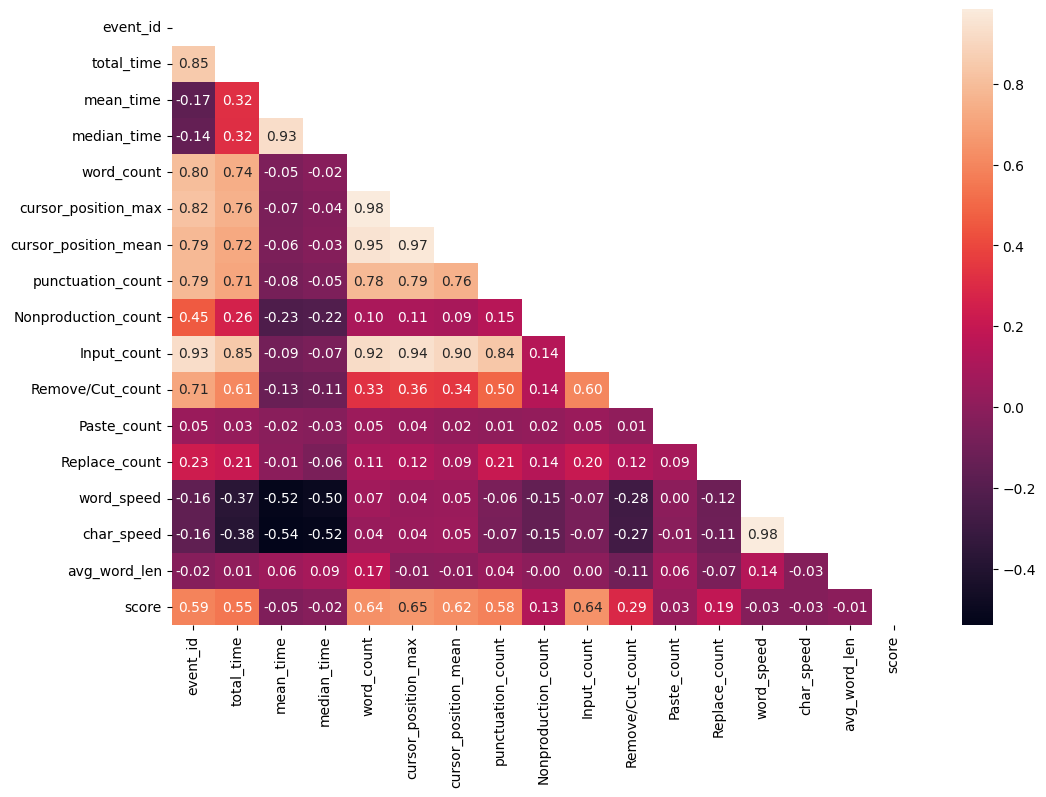

In [31]:
fig, ax = plt.subplots(figsize = (12, 8))
mask = np.triu(np.ones_like(corr_stats, dtype = bool))
sns.heatmap(
        corr_stats,
        annot = True,
        fmt = ".2f",
        mask = mask
        )
plt.show()

In [32]:
# Display which variables have the highest correlation with "score"
corr_stats["score"].sort_values(ascending = False)[1:11]

cursor_position_max     0.651429
Input_count             0.643891
word_count              0.635948
cursor_position_mean    0.622665
event_id                0.590769
punctuation_count       0.580467
total_time              0.545614
Remove/Cut_count        0.290776
Replace_count           0.186259
Nonproduction_count     0.128851
Name: score, dtype: float64

In [33]:
# Display which variables have the lowest correlation with "score"
corr_stats["score"].sort_values()[:5]

mean_time      -0.048502
word_speed     -0.033247
char_speed     -0.031932
median_time    -0.023416
avg_word_len   -0.006431
Name: score, dtype: float64

From this plot, it looks like the variables with the highest correlation to essay score are all related to total counts, such as `input_count` or the `cursor_position_max`. All of these variables strongly correlate with `word_count`. Meanwhile, variables not related to essay length, such as `word_speed` do not seem to have any correlation with `score`.

## Polars Feature Engineering and Helper Functions

In [34]:
def count_by_values(df, colname, values):
    """
    This function counts the occurrence of each value in a specified column (colname) across a DataFrame (df). For each unique value 
    in the list of values, it creates a new column in the DataFrame where each row represents the count of occurrences of that value.
    """
    fts = df.select(pl.col("id").unique(maintain_order = True))
    for i, value in enumerate(values):
        tmp_df = df.group_by("id")\
                .agg(pl.col(colname)\
                .is_in([value])\
                .sum()\
                .alias(f"{colname}_{i}_cnt"))
        fts = fts.join(tmp_df, on = "id", how = "left")
    return fts
                     
def dev_feats(df):
    """
    This function performs several types of feature engineering on the DataFrame (df)
    """
    
    print("< Count by values features >")
    
    # Create new columns representing the count of each activity, text change, down event, and up event
    feats = count_by_values(df, 'activity', CONFIG.activities)
    feats = feats.join(count_by_values(df, 'text_change', CONFIG.text_changes), on='id', how='left') 
    feats = feats.join(count_by_values(df, 'down_event', CONFIG.events), on='id', how='left') 
    feats = feats.join(count_by_values(df, 'up_event', CONFIG.events), on='id', how='left') 

    print("< Input words stats features >")

    # Calculate statistics on the length of words in the text_change column
    temp = df.filter((~pl.col('text_change').str.contains('=>')) & (pl.col('text_change') != 'NoChange'))
    temp = temp.group_by('id').agg(pl.col('text_change').str.concat('').str.extract_all(r'q+'))
    temp = temp.with_columns(input_word_count = pl.col('text_change').list.lengths(),
                             input_word_length_mean = pl.col('text_change').apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_max = pl.col('text_change').apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_std = pl.col('text_change').apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_median = pl.col('text_change').apply(lambda x: np.median([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_skew = pl.col('text_change').apply(lambda x: skew([len(i) for i in x] if len(x) > 0 else 0)))
    temp = temp.drop('text_change')
    feats = feats.join(temp, on='id', how='left') 


    
    print("< Numerical columns features >")

    # Calculate statistics columns specified in num_cols
    temp = df.group_by("id").agg(pl.sum('action_time').suffix('_sum'), pl.mean(CONFIG.num_cols).suffix('_mean'), pl.std(CONFIG.num_cols).suffix('_std'),
                                 pl.median(CONFIG.num_cols).suffix('_median'), pl.min(CONFIG.num_cols).suffix('_min'), pl.max(CONFIG.num_cols).suffix('_max'),
                                 pl.quantile(CONFIG.num_cols, 0.5).suffix('_quantile'))
    feats = feats.join(temp, on='id', how='left') 


    print("< Categorical columns features >")
    
    # Calculate the number of features for each of the specified columns
    temp  = df.group_by("id").agg(pl.n_unique(['activity', 'down_event', 'up_event', 'text_change']))
    feats = feats.join(temp, on='id', how='left') 


    
    print("< Idle time features >")

    # Calculate the difference in time between the "up_time" and the lagged "up_time", then calculate statistics
    temp = df.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
    temp = temp.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
    temp = temp.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.group_by("id").agg(inter_key_largest_lantency = pl.max('time_diff'),
                                   inter_key_median_lantency = pl.median('time_diff'),
                                   mean_pause_time = pl.mean('time_diff'),
                                   std_pause_time = pl.std('time_diff'),
                                   total_pause_time = pl.sum('time_diff'),
                                   pauses_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 0.5) & (pl.col('time_diff') < 1)).count(),
                                   pauses_1_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1) & (pl.col('time_diff') < 1.5)).count(),
                                   pauses_1_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1.5) & (pl.col('time_diff') < 2)).count(),
                                   pauses_2_sec = pl.col('time_diff').filter((pl.col('time_diff') > 2) & (pl.col('time_diff') < 3)).count(),
                                   pauses_3_sec = pl.col('time_diff').filter(pl.col('time_diff') > 3).count(),)
    feats = feats.join(temp, on='id', how='left') 
    
    print("< P-bursts features >")

    # Calculate the count of P-bursts, which are sequences of less than 2 seconds of keyboard activity
    temp = df.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
    temp = temp.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
    temp = temp.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.with_columns(pl.col('time_diff')<2)
    temp = temp.with_columns(pl.when(pl.col("time_diff") & pl.col("time_diff").is_last()).then(pl.count()).over(pl.col("time_diff").rle_id()).alias('P-bursts'))
    temp = temp.drop_nulls()
    temp = temp.group_by("id").agg(pl.mean('P-bursts').suffix('_mean'), pl.std('P-bursts').suffix('_std'), pl.count('P-bursts').suffix('_count'),
                                   pl.median('P-bursts').suffix('_median'), pl.max('P-bursts').suffix('_max'),
                                   pl.first('P-bursts').suffix('_first'), pl.last('P-bursts').suffix('_last'))
    feats = feats.join(temp, on='id', how='left') 


    print("< R-bursts features >")

    # Calculate the count of R-bursts, which are sequences of "Remove/Cut" activity
    temp = df.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.with_columns(pl.col('activity').is_in(['Remove/Cut']))
    temp = temp.with_columns(pl.when(pl.col("activity") & pl.col("activity").is_last()).then(pl.count()).over(pl.col("activity").rle_id()).alias('R-bursts'))
    temp = temp.drop_nulls()
    temp = temp.group_by("id").agg(pl.mean('R-bursts').suffix('_mean'), pl.std('R-bursts').suffix('_std'), 
                                   pl.median('R-bursts').suffix('_median'), pl.max('R-bursts').suffix('_max'),
                                   pl.first('R-bursts').suffix('_first'), pl.last('R-bursts').suffix('_last'))
    feats = feats.join(temp, on='id', how='left')
    
    return feats


def train_valid_split(data_x, data_y, train_idx, valid_idx):
    """
     This function splits the training data into training and validation sets based on the indices provided.
    """
    x_train = data_x.iloc[train_idx]
    y_train = data_y[train_idx]
    x_valid = data_x.iloc[valid_idx]
    y_valid = data_y[valid_idx]
    return x_train, y_train, x_valid, y_valid


def evaluate(data_x, data_y, model, random_state=42, n_splits=5, test_x=None):
    """
     This function evaluates a model using cross-validation. It trains the model on the training data and then predicts on the validation data. 
     If test_x is provided, it also predicts on the test data and returns the predictions.
    """
    skf    = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    test_y = np.zeros(len(data_x)) if (test_x is None) else np.zeros((len(test_x), n_splits))
    for i, (train_index, valid_index) in enumerate(skf.split(data_x, data_y.astype(str))):
        train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)
        model.fit(train_x, train_y)
        if test_x is None:
            test_y[valid_index] = model.predict(valid_x)
        else:
            test_y[:, i] = model.predict(test_x)
    return test_y if (test_x is None) else np.mean(test_y, axis=1)

## Pandas Feature Engineering and Helper Functions

In [35]:
# Calculate the first and third quartile for a given series x 
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

# A list of aggregations that will be applied to the data
AGGREGATIONS = ['count', 'mean', 'min', 'max', 'first', 'last', q1, 'median', q3, 'sum']

def reconstruct_essay(currTextInput):
    """
    This function takes a series of text inputs and reconstructs the essay text based on 
    the actions performed (like Replace, Paste, Remove/Cut, Move). It iterates over each 
    action in the series and applies the corresponding operation to the essay text.
    """
    essayText = ""
    for Input in currTextInput.values:
        # Input[0] = activity
        # Input[1] = cursor_position
        # Input[2] = text_change
        # Input[3] = id
        # If activity = Replace
        if Input[0] == 'Replace':
            # splits text_change at ' => '
            replaceTxt = Input[2].split(' => ')
            essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
            continue

        # If activity = Paste    
        if Input[0] == 'Paste':
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
            continue

        # If activity = Remove/Cut
        if Input[0] == 'Remove/Cut':
            essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
            continue

        # If activity = Move...
        if "M" in Input[0]:
            # Gets rid of the "Move from to" text
            croppedTxt = Input[0][10:]              
            # Splits cropped text by ' To '
            splitTxt = croppedTxt.split(' To ')              
            # Splits split text again by ', ' for each item
            valueArr = [item.split(', ') for item in splitTxt]              
            # Move from [2, 4] To [5, 7] = (2, 4, 5, 7)
            moveData = (int(valueArr[0][0][1:]), int(valueArr[0][1][:-1]), int(valueArr[1][0][1:]), int(valueArr[1][1][:-1]))
            # Skip if someone manages to activiate this by moving to same place
            if moveData[0] != moveData[2]:
                # Check if they move text forward in essay (they are different)
                if moveData[0] < moveData[2]:
                    essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] +\
                    essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                else:
                    essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] +\
                    essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
            continue                

        # If activity = input
        essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
    return essayText


def get_essay_df(df):
    """
    This function filters out non-productive activities, reconstructs the essay text for each user, 
    and returns a new DataFrame containing the reconstructed essays.
    """
    df       = df[df.activity != 'Nonproduction']
    temp     = df.groupby('id').apply(lambda x: reconstruct_essay(x[['activity', 'cursor_position', 'text_change']]))
    essay_df = pd.DataFrame({'id': df['id'].unique().tolist()})
    essay_df = essay_df.merge(temp.rename('essay'), on='id')
    return essay_df


def word_feats(df):
    essay_df = df
    df['word'] = df['essay'].apply(lambda x: re.split(' |\\n|\\.|\\?|\\!',x))
    df = df.explode('word')
    df['word_len'] = df['word'].apply(lambda x: len(x))
    df = df[df['word_len'] != 0]

    word_agg_df = df[['id','word_len']].groupby(['id']).agg(AGGREGATIONS)
    word_agg_df.columns = ['_'.join(x) for x in word_agg_df.columns]
    word_agg_df['id'] = word_agg_df.index
    word_agg_df = word_agg_df.reset_index(drop=True)
    return word_agg_df


def sent_feats(df):
    df['sent'] = df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
    df = df.explode('sent')
    df['sent'] = df['sent'].apply(lambda x: x.replace('\n','').strip())
    # Number of characters in sentences
    df['sent_len'] = df['sent'].apply(lambda x: len(x))
    # Number of words in sentences
    df['sent_word_count'] = df['sent'].apply(lambda x: len(x.split(' ')))
    df = df[df.sent_len!=0].reset_index(drop=True)

    sent_agg_df = pd.concat([df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), 
                             df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1)
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df


def parag_feats(df):
    df['paragraph'] = df['essay'].apply(lambda x: x.split('\n'))
    df = df.explode('paragraph')
    # Number of characters in paragraphs
    df['paragraph_len'] = df['paragraph'].apply(lambda x: len(x)) 
    # Number of words in paragraphs
    df['paragraph_word_count'] = df['paragraph'].apply(lambda x: len(x.split(' ')))
    df = df[df.paragraph_len!=0].reset_index(drop=True)
    
    paragraph_agg_df = pd.concat([df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), 
                                  df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1) 
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df

def product_to_keys(logs, essays):
    """
    This function calculates the ratio of the length of the product (essay) to the number of keys pressed to produce it.
    """
    essays['product_len'] = essays.essay.str.len()
    tmp_df = logs[logs.activity.isin(['Input', 'Remove/Cut'])].groupby(['id']).agg({'activity': 'count'}).reset_index().rename(columns={'activity': 'keys_pressed'})
    essays = essays.merge(tmp_df, on='id', how='left')
    essays['product_to_keys'] = essays['product_len'] / essays['keys_pressed']
    return essays[['id', 'product_to_keys']]

def get_keys_pressed_per_second(logs):
    """
    This function calculates the average number of keys pressed per second during the essay writing process.
    """
    temp_df = logs[logs['activity'].isin(['Input', 'Remove/Cut'])].groupby(['id']).agg(keys_pressed=('event_id', 'count')).reset_index()
    temp_df_2 = logs.groupby(['id']).agg(min_down_time=('down_time', 'min'), max_up_time=('up_time', 'max')).reset_index()
    temp_df = temp_df.merge(temp_df_2, on='id', how='left')
    temp_df['keys_per_second'] = temp_df['keys_pressed'] / ((temp_df['max_up_time'] - temp_df['min_down_time']) / 1000)
    return temp_df[['id', 'keys_per_second']]


## Optimizing Hyperparameters with Optuna

In [36]:
def objective(trial, x, y):
   param = {
       'metric': 'rmse',
       'random_state': CONFIG.seed,
       'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
       'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
       'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
       'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
       'subsample': trial.suggest_float('subsample', 0.5, 1),
       'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
       'max_depth': trial.suggest_int("max_depth", 1, 10),
       'num_leaves': trial.suggest_int('num_leaves', 2, 2**trial.suggest_int("max_depth", 1, 10)),
       'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
       'force_col_wise': True,
       'verbosity': -1,
   }

   model = LGBMRegressor(**param)

   # Split training data into train and validation datasets.
   train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.2)

   # Train model on train dataset.
   model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], early_stopping_rounds=100, verbose=False)

   # Predict on validation dataset.
   preds = model.predict(valid_x)

   # Compute RMSE.
   rmse = mean_squared_error(valid_y, preds, squared=False)

   return rmse

## Solution

In [37]:
data_path     = '/kaggle/input/linking-writing-processes-to-writing-quality/'
train_logs    = pl.scan_csv(data_path + 'train_logs.csv')
train_feats   = dev_feats(train_logs)
train_feats   = train_feats.collect().to_pandas()


print('< Essay Reconstruction >')
train_logs             = train_logs.collect().to_pandas()
train_essays           = get_essay_df(train_logs)
train_feats            = train_feats.merge(word_feats(train_essays), on='id', how='left')
train_feats            = train_feats.merge(sent_feats(train_essays), on='id', how='left')
train_feats            = train_feats.merge(parag_feats(train_essays), on='id', how='left')
train_feats            = train_feats.merge(get_keys_pressed_per_second(train_logs), on='id', how='left')
train_feats            = train_feats.merge(product_to_keys(train_logs, train_essays), on='id', how='left')


print('< Mapping >')
train_scores   = pd.read_csv(data_path + 'train_scores.csv')
data           = train_feats.merge(train_scores, on='id', how='left')
x              = data.drop(['id', 'score'], axis=1)
y              = data['score'].values
print(f'Number of features: {len(x.columns)}')


print('< Testing Data >')
test_logs   = pl.scan_csv(data_path + 'test_logs.csv')
test_feats  = dev_feats(test_logs)
test_feats  = test_feats.collect().to_pandas()

test_logs             = test_logs.collect().to_pandas()
test_essays           = get_essay_df(test_logs)
test_feats            = test_feats.merge(word_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(sent_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(parag_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(get_keys_pressed_per_second(test_logs), on='id', how='left')
test_feats            = test_feats.merge(product_to_keys(test_logs, test_essays), on='id', how='left')


test_ids = test_feats['id'].values
testin_x = test_feats.drop(['id'], axis=1)

print('< Learning and Evaluation >')

if CONFIG.use_optuna_tuning:
    study = optuna.create_study(direction='minimize', study_name='Optimize boosting hyperparameters')
    study.optimize(lambda trial: objective(trial, x, y), n_trials=CONFIG.num_trials_optuna)
    
if CONFIG.use_optuna_tuning:
    print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

if CONFIG.use_optuna_tuning:
    best_params = study.best_params

solution = LGBMRegressor(**best_params)
y_pred   = evaluate(x.copy(), y.copy(), solution, test_x=testin_x.copy()) 

sub = pd.DataFrame({'id': test_ids, 'score': y_pred})
sub.to_csv('submission.csv', index=False)

< Count by values features >
< Input words stats features >
< Numerical columns features >
< Categorical columns features >
< Idle time features >
< P-bursts features >
< R-bursts features >
< Essay Reconstruction >
< Mapping >
Number of features: 164
< Testing Data >
< Count by values features >
< Input words stats features >
< Numerical columns features >
< Categorical columns features >
< Idle time features >
< P-bursts features >
< R-bursts features >


[I 2024-01-03 17:27:41,090] A new study created in memory with name: Optimize boosting hyperparameters


< Learning and Evaluation >


[I 2024-01-03 17:27:48,134] Trial 0 finished with value: 0.64769147261431 and parameters: {'n_estimators': 906, 'reg_alpha': 0.6937192269393551, 'reg_lambda': 0.007057223887600204, 'colsample_bytree': 0.8296301107694001, 'subsample': 0.7298098395344554, 'learning_rate': 0.0020082628388071915, 'max_depth': 7, 'num_leaves': 78, 'min_child_samples': 65}. Best is trial 0 with value: 0.64769147261431.
[I 2024-01-03 17:27:48,539] Trial 1 finished with value: 0.600530856803788 and parameters: {'n_estimators': 727, 'reg_alpha': 2.760049828977017, 'reg_lambda': 0.0029402824199180983, 'colsample_bytree': 0.6988387277239798, 'subsample': 0.6189710062060304, 'learning_rate': 0.08031175939379927, 'max_depth': 2, 'num_leaves': 4, 'min_child_samples': 6}. Best is trial 1 with value: 0.600530856803788.
[I 2024-01-03 17:27:48,778] Trial 2 finished with value: 0.640456757008405 and parameters: {'n_estimators': 170, 'reg_alpha': 2.820719277744576, 'reg_lambda': 2.8012777081734246, 'colsample_bytree': 0.9

Best trial: score 0.566295600108965, params {'n_estimators': 256, 'reg_alpha': 0.12782948929761326, 'reg_lambda': 1.5515534228034666, 'colsample_bytree': 0.8923232722192607, 'subsample': 0.93485283751295, 'learning_rate': 0.017864114588853848, 'max_depth': 8, 'num_leaves': 61, 'min_child_samples': 71}


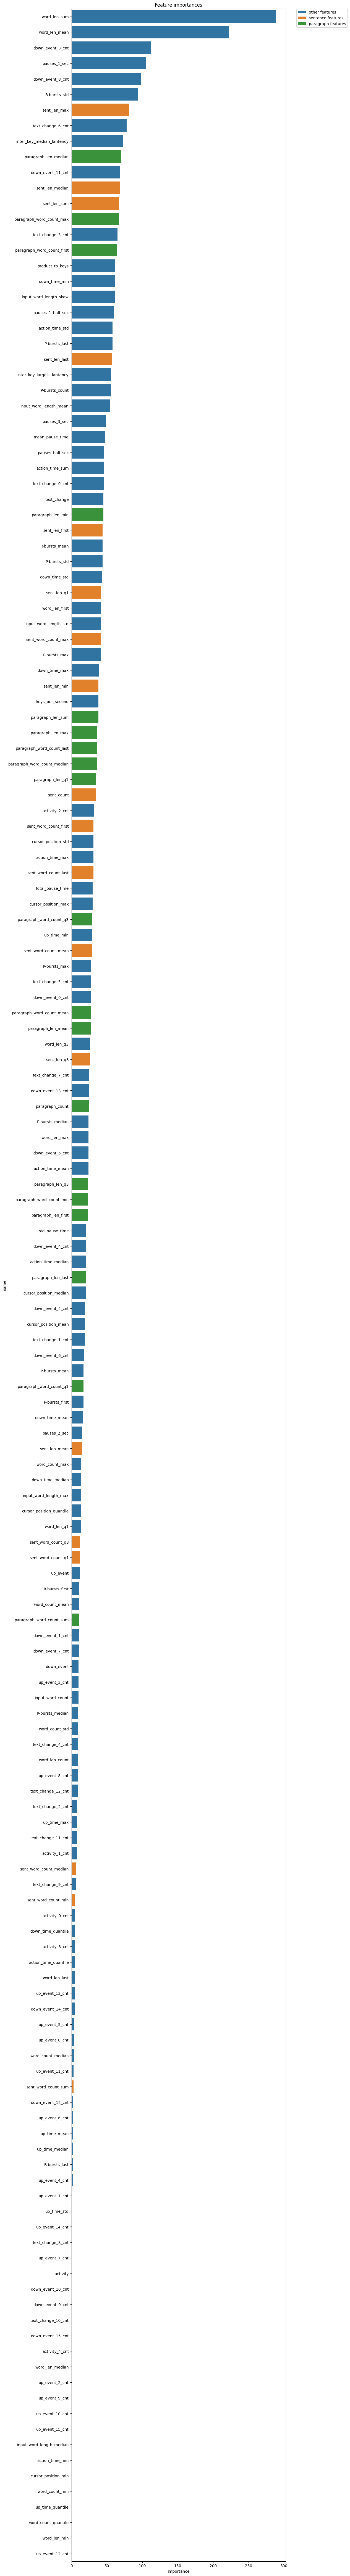

In [38]:
# Get feature importances from the model
feature_importances = solution.feature_importances_

# Create a dataframe to hold feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'name': x.columns, 'importance': feature_importances})

# Sort the dataframe by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Group features based on their names
feature_importance_df['group'] = feature_importance_df['name'].apply(
  lambda x: 'sentence features' if 'sent' in x else 'paragraph features' if 'paragraph' in x else 'other features')

# Plot the feature importances
plt.figure(figsize=(10, 120))
ax = sns.barplot(data=feature_importance_df, x='importance', y='name', hue='group', dodge=False)
ax.set_title(f"Feature importances")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
